In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft, ifft, dct

In [4]:
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()

In [5]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']

In [94]:
def mspec_func(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

In [97]:
def mfcc_func(samples, winlen = 400, winshift = 200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    mspecs = mspec_func(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)

In [8]:
def trfbank(fs, nfft, lowfreq=133.33, linsc=200/3., logsc=1.0711703, nlinfilt=13, nlogfilt=27, equalareas=False):
    """Compute triangular filterbank for MFCC computation.

    Inputs:
    fs:         sampling frequency (rate)
    nfft:       length of the fft
    lowfreq:    frequency of the lowest filter
    linsc:      scale for the linear filters
    logsc:      scale for the logaritmic filters
    nlinfilt:   number of linear filters
    nlogfilt:   number of log filters

    Outputs:
    res:  array with shape [N, nfft], with filter amplitudes for each column.
            (N=nlinfilt+nlogfilt)
    From scikits.talkbox"""
    # Total number of filters
    nfilt = nlinfilt + nlogfilt

    #------------------------
    # Compute the filter bank
    #------------------------
    # Compute start/middle/end points of the triangular filters in spectral
    # domain
    freqs = np.zeros(nfilt+2)
    freqs[:nlinfilt] = lowfreq + np.arange(nlinfilt) * linsc
    freqs[nlinfilt:] = freqs[nlinfilt-1] * logsc ** np.arange(1, nlogfilt + 3)
    if equalareas:
        heights = np.ones(nfilt)
    else:
        heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((nfilt, nfft))
    # FFT bins (in Hz)
    nfreqs = np.arange(nfft) / (1. * nfft) * fs
    for i in range(nfilt):
        low = freqs[i]
        cen = freqs[i+1]
        hi = freqs[i+2]

        lid = np.arange(np.floor(low * nfft / fs) + 1,
                        np.floor(cen * nfft / fs) + 1, dtype=np.int)
        lslope = heights[i] / (cen - low)
        rid = np.arange(np.floor(cen * nfft / fs) + 1,
                        np.floor(hi * nfft / fs) + 1, dtype=np.int)
        rslope = heights[i] / (hi - cen)
        fbank[i][lid] = lslope * (nfreqs[lid] - low)
        fbank[i][rid] = rslope * (hi - nfreqs[rid])

    return fbank

In [84]:
def lifter(mfcc, lifter=22):
    """
    Applies liftering to improve the relative range of MFCC coefficients.

       mfcc: NxM matrix where N is the number of frames and M the number of MFCC coefficients
       lifter: lifering coefficient

    Returns:
       NxM array with lifeterd coefficients
    """
    nframes, nceps = mfcc.shape
    cepwin = 1.0 + lifter/2.0 * np.sin(np.pi * np.arange(nceps) / lifter)
    return np.multiply(mfcc, np.tile(cepwin, nframes).reshape((nframes,nceps)))

In [9]:
def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    idx = 0
    ans = []
    while idx < samples.size - winlen:
      ans.append(samples[int(idx):int(idx+winlen)])
      idx += winshift

    return np.array(ans)

In [10]:
def preemp(input, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        input: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """
    ans = []

    for row in input:
      ans.append(signal.lfilter([1, -p], [1], row))

    return np.array(ans)

In [99]:
def windowing(input):
    """
    Applies hamming window to the input frames.

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """
    ans = []
    window = signal.hamming(preemph.shape[1], sym=0)

    for row in input:
      ans.append(row * window)

    return np.array(ans)

In [12]:
def powerSpectrum(input, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        input: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """
    ans = []

    for row in input:
      ans.append( abs(fft(row, nfft))**2 )

    return np.array(ans)

In [51]:
def logMelSpectrum(input, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        input: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """

    tr_bank = trfbank(samplingrate, 512)

    ans = input @ tr_bank.T
    
    return np.log(np.array(ans))

In [74]:
def cepstrum(input, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        input: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """
    
    return dct(input)[:, :nceps]

In [15]:
def dtw(x, y, dist):
    """Dynamic Time Warping.

    Args:
        x, y: arrays of size NxD and MxD respectively, where D is the dimensionality
              and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        d: global distance between the sequences (scalar) normalized to len(x)+len(y)
        LD: local distance between frames from x and y (NxM matrix)
        AD: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough AD

    Note that you only need to define the first output for this exercise.
    """
    #TODO
    pass

# Mel-frequency cepstrum coefficients

[]

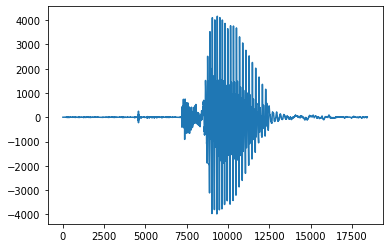

In [16]:
plt.plot(example['samples'])
plt.plot()

## Enframe

In [17]:
window_length = 20 #ms
window_shift = 10 #ms

winlen = window_length * example['samplingrate'] / 1000
winshift = window_shift * example['samplingrate'] / 1000

enframed = enframe(example['samples'], winlen, winshift)
(enframed==example['frames']).all()

True

[]

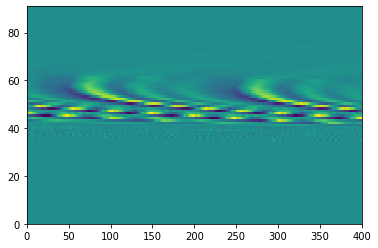

In [18]:
plt.pcolormesh(enframed)
plt.plot()

## Pre-emphasis

In [19]:
preemph = preemp(enframed)
(example['preemph']==preemph).all()

True

[]

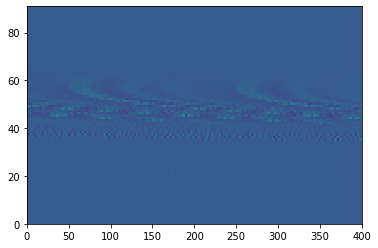

In [20]:
plt.pcolormesh(preemph)
plt.plot()

## Hamming Window

[]

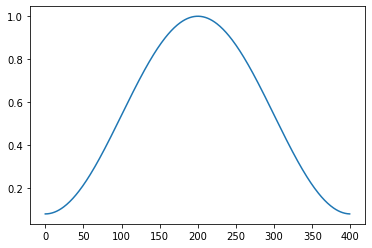

In [21]:
window = signal.hamming(preemph.shape[1], sym=0)
plt.plot(window)
plt.plot()

In [22]:
windowed = windowing(example['preemph'])

In [23]:
(example['windowed']==windowed).all()

True

## Fast Fourier Transform

In [24]:
nfft = 512

spec = powerSpectrum(example['windowed'], nfft)

In [25]:
(example['spec']==spec).all()

False

In [50]:
# We add a threshold
(abs(spec - example['spec']) < 1e-6).all()

True

[]

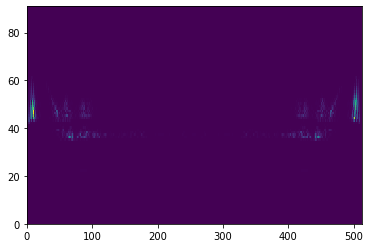

In [27]:
plt.pcolormesh(example['spec'])
plt.plot()

[]

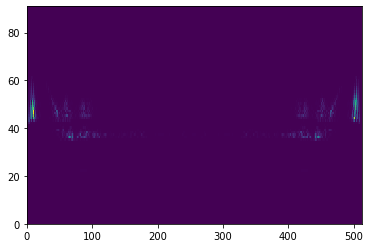

In [28]:
plt.pcolormesh(spec)
plt.plot()

## Mel filterbank log spectrum

(91, 40)


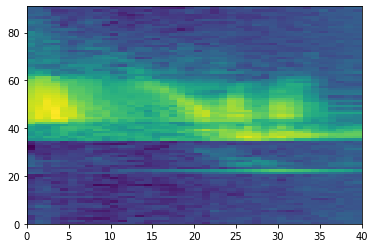

In [37]:
print(example['mspec'].shape)
plt.pcolormesh(example['mspec'])
plt.show()

In [38]:
example['spec'].shape

(91, 512)

In [52]:
mspec = logMelSpectrum(example['spec'], example['samplingrate'])
(abs(mspec - example['mspec']) < 1e-6).all()

True

## Cosine Transform and Liftering

(91, 13)


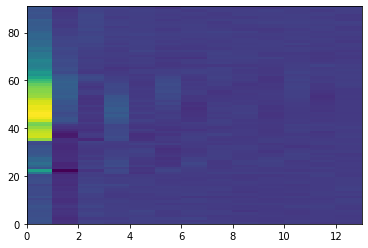

In [56]:
print(example['mfcc'].shape)
plt.pcolormesh(example['mfcc'])
plt.show()

In [77]:
mfcc = cepstrum(example['mspec'], 13)

In [82]:
(abs(mfcc - example['mfcc']) < 1e-6).all()

True

In [85]:
(abs(lifter(mfcc) - example['lmfcc']) < 1e-6).all()

True

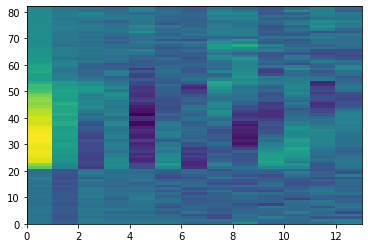

Gender: man	Digit: o


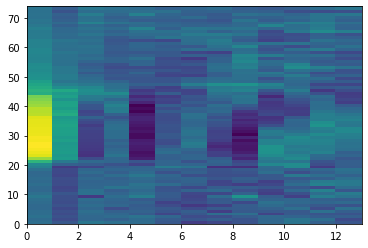

Gender: man	Digit: o


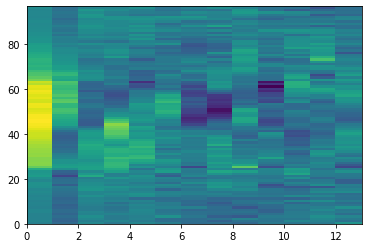

Gender: man	Digit: z


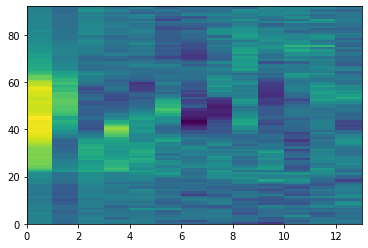

Gender: man	Digit: z


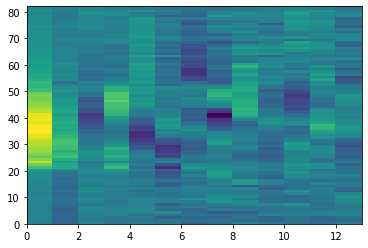

Gender: man	Digit: 1


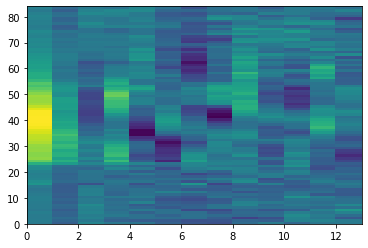

Gender: man	Digit: 1


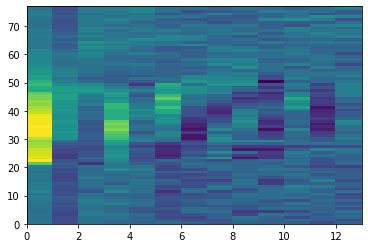

Gender: man	Digit: 2


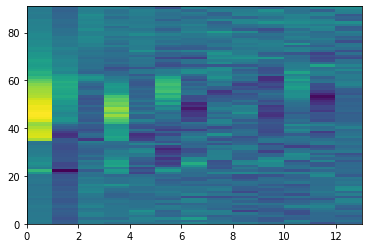

Gender: man	Digit: 2


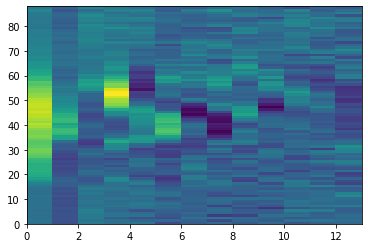

Gender: man	Digit: 3


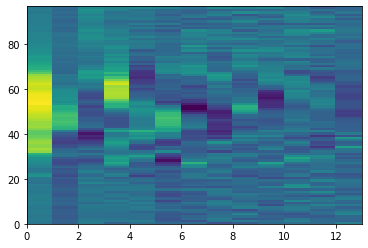

Gender: man	Digit: 3


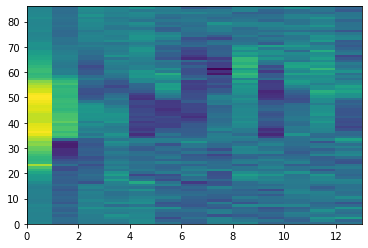

Gender: man	Digit: 4


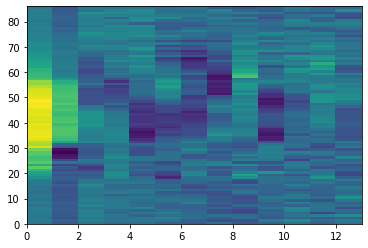

Gender: man	Digit: 4


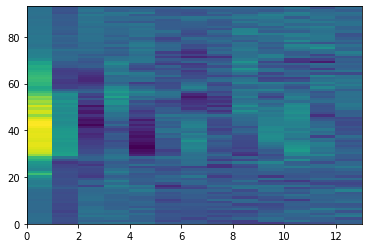

Gender: man	Digit: 5


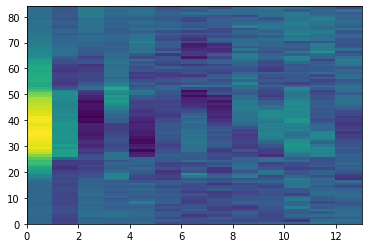

Gender: man	Digit: 5


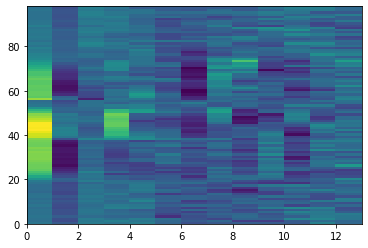

Gender: man	Digit: 6


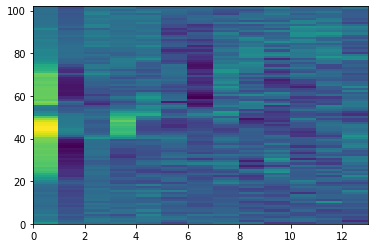

Gender: man	Digit: 6


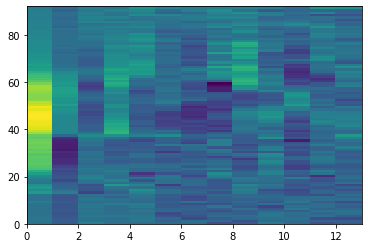

Gender: man	Digit: 7


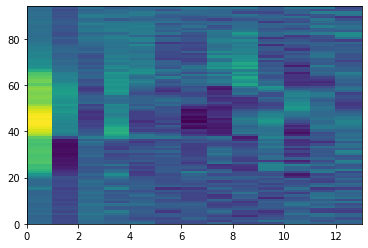

Gender: man	Digit: 7


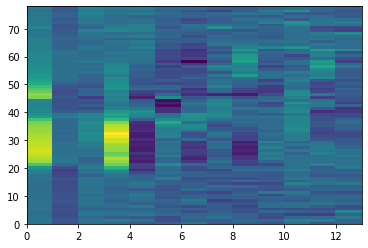

Gender: man	Digit: 8


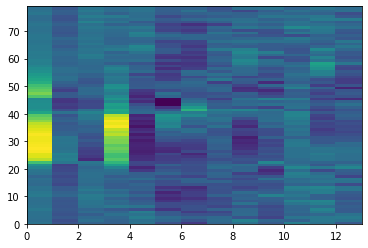

Gender: man	Digit: 8


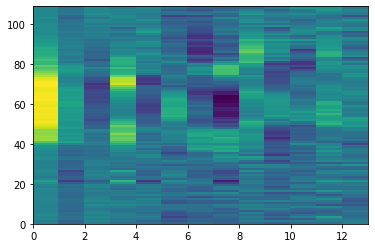

Gender: man	Digit: 9


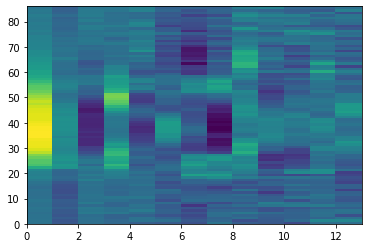

Gender: man	Digit: 9


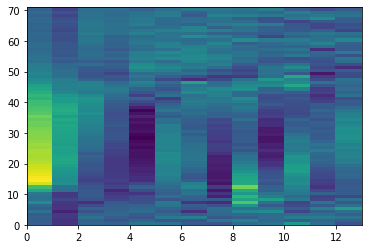

Gender: woman	Digit: o


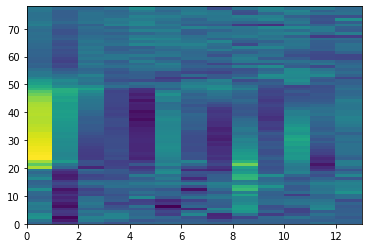

Gender: woman	Digit: o


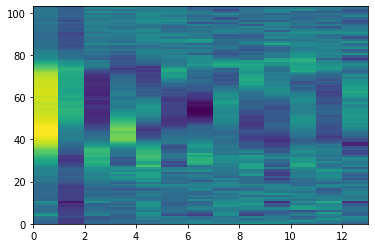

Gender: woman	Digit: z


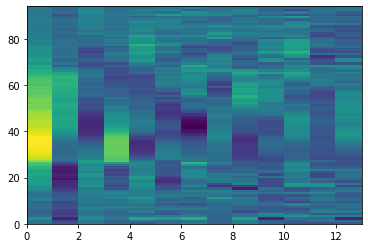

Gender: woman	Digit: z


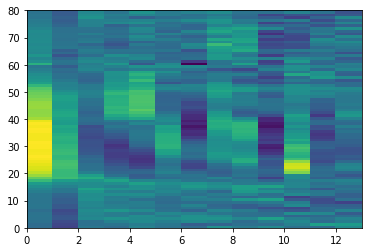

Gender: woman	Digit: 1


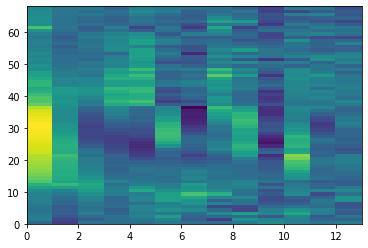

Gender: woman	Digit: 1


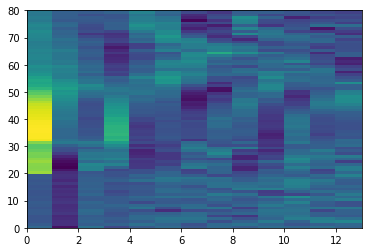

Gender: woman	Digit: 2


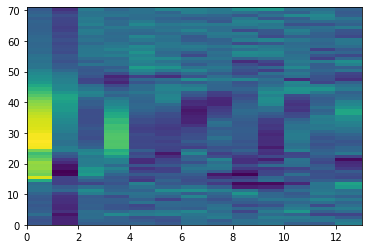

Gender: woman	Digit: 2


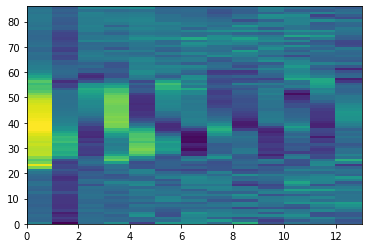

Gender: woman	Digit: 3


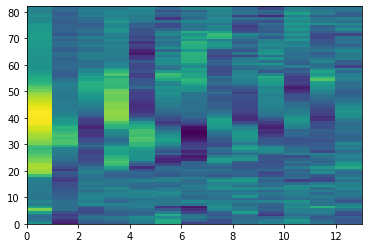

Gender: woman	Digit: 3


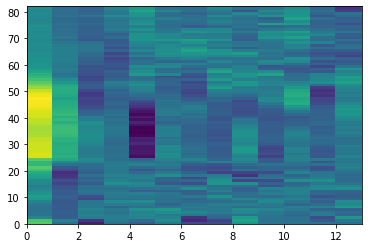

Gender: woman	Digit: 4


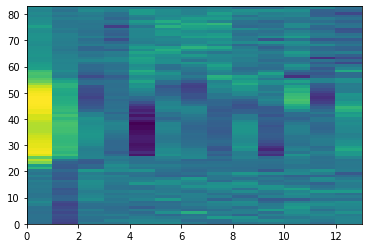

Gender: woman	Digit: 4


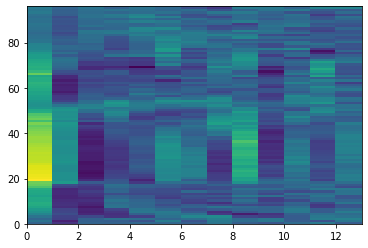

Gender: woman	Digit: 5


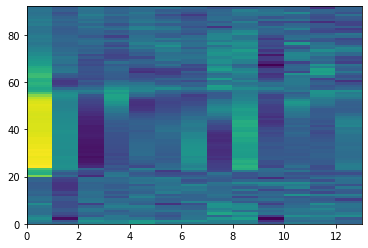

Gender: woman	Digit: 5


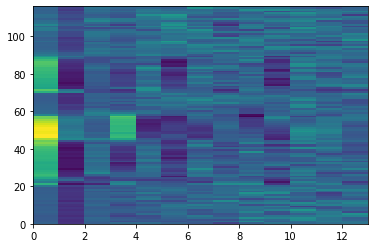

Gender: woman	Digit: 6


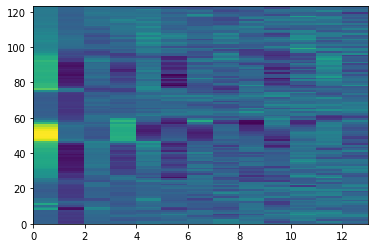

Gender: woman	Digit: 6


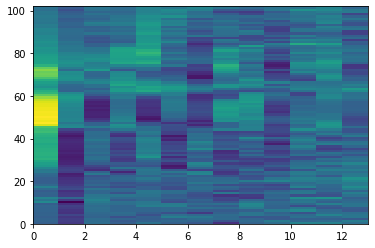

Gender: woman	Digit: 7


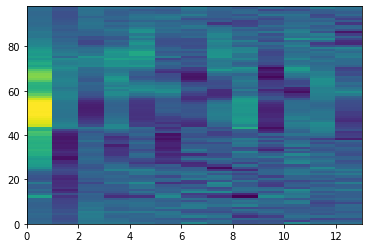

Gender: woman	Digit: 7


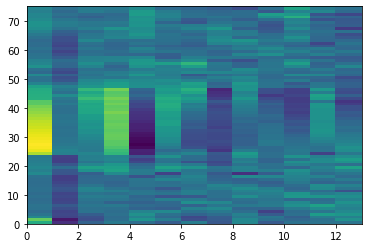

Gender: woman	Digit: 8


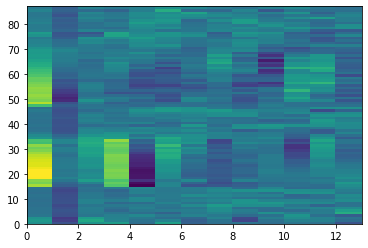

Gender: woman	Digit: 8


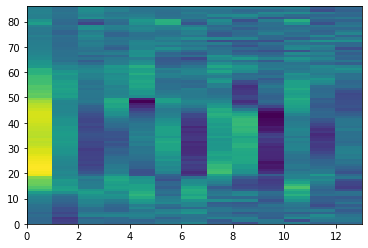

Gender: woman	Digit: 9


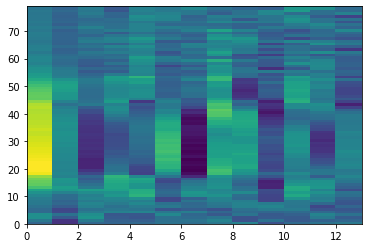

Gender: woman	Digit: 9


In [105]:
for data_point in data:
  plt.pcolormesh(mfcc_func(data_point['samples']))
  plt.show()
  print("Gender: {}\tDigit: {}".format(data_point['gender'], data_point['digit']))